# DBTL1: Filter recommendations
In `DBTL3_B_art_modeling_and_recommend.ipynb` we generated ART predictions of all possible combinations of up to 4 different CRISPRi gRNAs. 

Here, we will define a filtering strategy for the recommendations and use it to generate recommendations for DBTL4.

We import all recommendations, and then define a 

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import resource
# Convert 4GB to bytes
memory_limit = 16 * 1024 * 1024 * 1024

# Set the memory limit
resource.setrlimit(resource.RLIMIT_DATA, (memory_limit, memory_limit))

In [4]:
fig_loc = './dbtl4_figures_and_analysis/'
art_path = 'dbtl4_art_outputs/art.cpkl'
rec_df = pd.read_pickle('./dbtl4_figures_and_analysis/dbtl4_rec_df_filtered_training_data.pkl')
data_df = pd.read_pickle(f'./dbtl4_figures_and_analysis/dbtl3_dbtl4_isoprenol_processed_df.pkl')


## 1 Import `rec_df`, `data_df`, and trained ART model.

Import recommendation dataframe

In [5]:
# rec_df = pd.read_pickle('./dbtl3_figures_and_analysis/dbtl0_dbtl1_dbtl3_rec_df_filtered_training_data.pkl')
# rec_df = pd.read_pickle('./dbtl3ONLY_figures_and_analysis/dbtl3_rec_df_filtered_training_data.pkl')

Dataframe of training data

In [6]:
# data_df = pd.read_pickle(f'./dbtl3ONLY_figures_and_analysis/dbtl0_dbtl1_dbtl3_isoprenol_processed_df.pkl')
# data_df = pd.read_pickle(f'./dbtl3ONLY_figures_and_analysis/dbtl0_dbtl1_dbtl3_isoprenol_processed_df.pkl')

Sort `rec_df` and take a small subset from the top of the dataframe.

In [7]:
# rec_df = rec_df.sort_values(by = 'pp_mean', ascending = False).iloc[:500000,:]
rec_df = rec_df.sort_values(by = 'pp_mean', ascending = False)

Get the columns related to gRNA (perturbations) from the recs.

In [8]:
pert_columns = rec_df.columns[:-2]

In [9]:
data_df.head(3)

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
789,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,mg/L,473.4303,1,PP_0528_PP_0813_PP_0815_PP_1317,None,3,False,"[PP_0528, PP_0813, PP_0815, PP_1317]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_0815_PP_1317-R1
790,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,mg/L,325.8933,1,PP_0528_PP_0813_PP_4191,None,3,False,"[PP_0528, PP_0813, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_4191-R1
791,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,mg/L,372.1794,1,PP_0528_PP_0814_PP_4191,None,3,False,"[PP_0528, PP_0814, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0814_PP_4191-R1


In [10]:
# dbtl2_data_df['line_name_norep'] = dbtl2_data_df['Line Name'].apply(lambda x: x[:-3])
# dbtl2_data_df

### 1.1 Add information to `rec_df`
Since we generated recs for all possible combinations of gRNA, some of the recs are in the experimental data. It would be useful to check if recommendations are in the experimental data or not.

First, add a `number_of_grna` column to recommendations to make them easier to filter.

In [11]:
rec_df['number_of_grna'] = rec_df.loc[:, pert_columns].apply(sum, axis = 1).astype(int)

Add indicator column to `rec_df`

In [12]:
rec_df['in_expt'] = 0

Iterate through rows of experimental data (since there is less of it)

In [13]:
for idx, expt_row in data_df.iterrows():
    n_grna_expt = expt_row['number_of_grna']
    rec_df_subset = rec_df[rec_df['number_of_grna']==n_grna_expt]
    
    matching_subset_index = (
        (np.all(rec_df.loc[:, pert_columns] == expt_row[pert_columns], axis = 1)) & 
        (rec_df.loc[:, 'number_of_grna'] == n_grna_expt)
    )
    assert sum(matching_subset_index)==1, 'ERROR: experimental data missing from recommendations'
    rec_df_index = rec_df_subset.loc[matching_subset_index,:].index
    rec_df.loc[rec_df_index, 'in_expt'] = True

/tmp/ipykernel_486/1782491175.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rec_df.loc[rec_df_index, 'in_expt'] = True


In [14]:
rec_df = rec_df[rec_df['in_expt'] == 0]

In [15]:
rec_df[rec_df['in_expt'] == 1]['number_of_grna'].value_counts()

Series([], Name: count, dtype: int64)

In [16]:
data_df.loc[data_df['cycle']==3,:]

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
789,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,mg/L,473.4303,1,PP_0528_PP_0813_PP_0815_PP_1317,None,3,False,"[PP_0528, PP_0813, PP_0815, PP_1317]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_0815_PP_1317-R1
790,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,mg/L,325.8933,1,PP_0528_PP_0813_PP_4191,None,3,False,"[PP_0528, PP_0813, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_4191-R1
791,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,mg/L,372.1794,1,PP_0528_PP_0814_PP_4191,None,3,False,"[PP_0528, PP_0814, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0814_PP_4191-R1
792,PP_0528_PP_0751_PP_4191-R1,DBTL3_P1_004,mg/L,400.7445,1,PP_0528_PP_0751_PP_4191,None,3,False,"[PP_0528, PP_0751, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0751_PP_4191-R1
793,PP_0528_PP_0815_PP_4191-R1,DBTL3_P1_005,mg/L,398.0633,1,PP_0528_PP_0815_PP_4191,None,3,False,"[PP_0528, PP_0815, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0815_PP_4191-R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,PP_0815_PP_1317-R3,DBTL3_P4_041,mg/L,380.1841,3,PP_0815_PP_1317,None,3,False,"[PP_0815, PP_1317]",...,0,0,0,0,0,0,True,True,3,PP_0815_PP_1317-R3
968,PP_0528_PP_0815_PP_1317_P4-R3,DBTL3_P4_042,mg/L,387.5350,3,PP_0528_PP_0815_PP_1317_P4,None,3,False,"[PP_0528, PP_0815, PP_1317]",...,0,0,0,0,0,0,True,False,3,PP_0528_PP_0815_PP_1317_P4-R3
969,PP_0812_PP_1769-R3,DBTL3_P4_043,mg/L,364.8823,3,PP_0812_PP_1769,None,3,False,"[PP_0812, PP_1769]",...,0,0,0,0,0,0,True,False,3,PP_0812_PP_1769-R3
970,PP_0368_PP_4189_P4-R3,DBTL3_P4_044,mg/L,240.6646,3,PP_0368_PP_4189_P4,None,3,False,"[PP_0368, PP_4189]",...,0,0,0,0,0,0,True,False,3,PP_0368_PP_4189_P4-R3


In [17]:
data_df[data_df['has_cycle1_gene']]['number_of_grna'].value_counts()

number_of_grna
3    159
2    153
4     27
1      6
Name: count, dtype: int64

### 1.X Remove recs with non DBTL3 gRNA in them

In [18]:
data_df['sorted_gene_list']
all_dbtl34_genes = list(
    np.unique(
        np.array(
            [
                g for gl in data_df['sorted_gene_list']
                for g in gl
            ]
        )
    )
)
all_gene_columns = rec_df.columns[:-4]
non_dbtl34_columns = [gene_column for gene_column in all_gene_columns if gene_column not in all_dbtl34_genes]


print(f'There are N = {len(all_gene_columns)} total columns, N = {len(all_dbtl34_genes)} are in dbtl3 and N = {len(non_dbtl34_columns)} not in dbtl3')
assert len(non_dbtl34_columns) + len(all_dbtl34_genes) == len(all_gene_columns)

There are N = 57 total columns, N = 16 are in dbtl3 and N = 41 not in dbtl3


In [19]:
rec_df['non_dbtl34_gene'] = np.any(rec_df.loc[:, non_dbtl34_columns], axis = 1)

In [20]:
rec_df.loc[~rec_df['non_dbtl34_gene'], 'number_of_grna'].value_counts()

number_of_grna
4    1811
3     510
2      70
1      14
Name: count, dtype: int64

In [21]:
rec_df = rec_df.loc[~rec_df['non_dbtl34_gene']]

## 2. Filter recs and save final recs for DBTL3
Define the following variables:

- `N_total_recs`: The total number of recommendations.
- `N_grna_dict`: A dictionary defining how many recommendations of each length are requrested. Entries are formatted as {number of gRNA: number of recs}. 
- `max_grna_appearances`: A number controlling how many times a single guide RNA can show up in the recommendations.

Create an indicator column for whether a candidate recommendation should be kept.

In [22]:
rec_df['to_rec'] = 0

### 2.1 Define functions to identify recommendations
We will iterate through `rec_df` and selectively identify candidate recommendations to keep.

In [23]:
write_line_name = lambda x: '_'.join(pert_columns[np.where(x == 1)])

In [24]:
n_total_recs = 100
n_grna_dict = {0: 0,
               1: 0,
               2: 40,
               3: 50,
               4: 10,
               5: 0}

assert sum(n_grna_dict.values()) == n_total_recs, "Number of total recs should equal the num of N_gRNA in N_grna_dict"

max_grna_appearances = 25
max_grna_appearances_per_ngrna = 15

Create variables to track how many of each gRNA length we've added, and how many of each gRNA.

Then, iterate through rec_df. At each iteration:

1. Get the number of gRNA and the gRNA identities of the current candidate.
2. Check how many recommendations already have the number of gRNA and gRNA identities of current candidate.
3. If the current recommendation is allowed (doesn't exceed the number of gRNA lengths or gRNA appearances), change `rec_df['to_rec']` to 1.

End loop once the required number of reqs (`n_total_recs`) is reached.

In [25]:
grna_len_tracker = {0: 0,
                    1: 0,
                    2: 0,
                    3: 0,
                    4: 0,
                    5: 0}
grna_tracker = dict(zip(pert_columns.values, [0 for i in range(len(pert_columns))]))
grna_tracker_by_length = pd.DataFrame(index = n_grna_dict.keys(), columns = pert_columns, data = 0)
n_recs_added = 0
n_recs_skipped = 0
rec_list = []
for rec_idx, rec_data in rec_df.iterrows():
    #Get values to check whether to keep this rec
    current_grna_length = rec_data['number_of_grna']
    current_grna = pert_columns[np.where(rec_data[pert_columns] == 1)].values

    #Get values from trackers for recommendations and recommendation lengths
    # already_recommended_grna = np.array([grna_tracker[grna] for grna in current_grna])
    already_recommended_grna = grna_tracker_by_length.loc[current_grna_length, current_grna].values
    already_recommended_lengths = grna_len_tracker[current_grna_length]
    
    # print(f'Already recommended grna: {already_recommended_grna}\t already recommended lengths: {already_recommended_lengths}')
    
    if np.any(already_recommended_grna>=max_grna_appearances_per_ngrna) or already_recommended_lengths>=n_grna_dict[current_grna_length]:
        n_recs_skipped += 1
    else:
        print(f'\nadding rec: {rec_idx}')
        print(f'Rec Idx: {rec_idx}\tCurrent grna: {current_grna}\tCurrent grna length: {current_grna_length}')
        print(f'Already recommended grna: {already_recommended_grna}\t already recommended lengths: {already_recommended_lengths}')

        rec_df.loc[rec_idx, 'to_rec'] = 1
        grna_len_tracker[current_grna_length] += 1
        for current_single_grna in current_grna:
            grna_tracker[current_single_grna] += 1
            grna_tracker_by_length.loc[current_grna_length, current_single_grna] += 1
        n_recs_added+=1
        rec_list.append(list(current_grna))
        # print(rec_list)
        # print('\n')
    if n_recs_added >= n_total_recs:
        print('Number of total recs reached, breaking')
        print('~~~~~~~~~~~~~~~~~~~~~')
        break
    # if n_recs_added>20:
    #     break
print(f'Number of skipped candidates: {n_recs_skipped}\t Number of added candidates: {n_recs_added}')


adding rec: 64095
Rec Idx: 64095	Current grna: ['PP_0368' 'PP_0751' 'PP_0812' 'PP_0815']	Current grna length: 4
Already recommended grna: [0 0 0 0]	 already recommended lengths: 0

adding rec: 66548
Rec Idx: 66548	Current grna: ['PP_0368' 'PP_0812' 'PP_0815' 'PP_1769']	Current grna length: 4
Already recommended grna: [1 1 1 0]	 already recommended lengths: 1

adding rec: 66446
Rec Idx: 66446	Current grna: ['PP_0368' 'PP_0812' 'PP_0813' 'PP_0815']	Current grna length: 4
Already recommended grna: [2 2 0 2]	 already recommended lengths: 2

adding rec: 177201
Rec Idx: 177201	Current grna: ['PP_0751' 'PP_0812' 'PP_0813' 'PP_0815']	Current grna length: 4
Already recommended grna: [1 3 1 3]	 already recommended lengths: 3

adding rec: 66551
Rec Idx: 66551	Current grna: ['PP_0368' 'PP_0812' 'PP_0815' 'PP_2136']	Current grna length: 4
Already recommended grna: [3 4 4 0]	 already recommended lengths: 4

adding rec: 10140
Rec Idx: 10140	Current grna: ['PP_0751' 'PP_0812' 'PP_0815']	Current grna 

In [26]:
grna_tracker_by_length

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4266,PP_4549,PP_4550,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,6,6,4,0,0,9,0,9,5,...,0,0,0,0,0,0,0,0,0,0
3,0,15,6,5,0,0,15,0,15,15,...,0,0,0,0,0,0,0,0,0,0
4,0,6,1,1,0,0,3,0,10,4,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
assert rec_df['to_rec'].sum() == n_total_recs, 'ERROR: incorrect number of recommendations'

### 2.2 Create dataframe for filtered recs

In [28]:
filtered_recs = rec_df[rec_df['to_rec'] == 1].copy()

In [29]:
filtered_recs = filtered_recs.sort_values('pp_mean', ascending=False)

Add human-readable line name to recs_df

In [30]:
filtered_recs['line_name'] = filtered_recs.loc[:,pert_columns].apply(write_line_name, axis = 1)

In [31]:
filtered_recs.head(5)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name
64095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,604.560826,57.238152,4,0,False,1,PP_0368_PP_0751_PP_0812_PP_0815
66548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,603.759234,57.064168,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_1769
66446,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,603.182441,57.152095,4,0,False,1,PP_0368_PP_0812_PP_0813_PP_0815
177201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,603.005291,57.170639,4,0,False,1,PP_0751_PP_0812_PP_0813_PP_0815
66551,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,602.587095,57.229088,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_2136


### 2.3 Cross-reference recs against ART0/1/2

In [32]:
art012_rec_df = pd.read_pickle('./dbtl2_figures_and_analysis/dbtl0_dbtl1_dbtl2_rec_df_filtered_training_data.pkl')
art012_path = './dbtl2_art_outputs/art.cpkl'
with open(art012_path, 'rb') as art_file:
    art012 = cloudpickle.load(art_file)

In [33]:
filtered_recs.loc[:,'art012_pp_mean'] = np.nan
filtered_recs.loc[:,'art012_pp_std'] = np.nan


for idx, filtered_rec in filtered_recs.iterrows():
    split_targets = np.sort(re.findall('PP_[0-9]{4}', filtered_rec['line_name']))
    num_grna = filtered_rec['number_of_grna']
    
    art012_rec_idx = (
        (
            np.all(
                np.stack(
                    [np.array(art012_rec_df[target_column] == 1) for target_column in split_targets]
                ), 
                axis = 0)
        ) &
        (art012_rec_df.loc[:, pert_columns].sum(axis = 1) == num_grna)
    )
    assert sum(art012_rec_idx) == 1
    filtered_recs.loc[idx, ['art012_pp_mean', 'art012_pp_std']] = art012_rec_df.loc[art012_rec_idx, ['pp_mean', 'pp_std']].values    

In [34]:
filtered_recs

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name,art012_pp_mean,art012_pp_std
64095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,604.560826,57.238152,4,0,False,1,PP_0368_PP_0751_PP_0812_PP_0815,361.709215,48.626924
66548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,603.759234,57.064168,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_1769,359.827872,49.725108
66446,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,603.182441,57.152095,4,0,False,1,PP_0368_PP_0812_PP_0813_PP_0815,405.488874,48.525895
177201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,603.005291,57.170639,4,0,False,1,PP_0751_PP_0812_PP_0813_PP_0815,384.549541,48.566169
66551,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,602.587095,57.229088,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_2136,345.689825,48.550383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,292.627372,57.126275,2,0,False,1,PP_1317_PP_4191,315.799209,48.241757
815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,292.202769,57.129970,2,0,False,1,PP_1317_PP_4120,200.834022,48.154017
488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,291.430655,57.029401,2,0,False,1,PP_0812_PP_1506,240.480841,48.142790
228,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,291.378587,57.061361,2,0,False,1,PP_0528_PP_0813,357.356237,48.481320


#### Filter out ART0/1/2 bad strains

In [35]:
art012_threshold = 300
delta_pred_threshold = 50

In [36]:
filtered_recs['art012_drop'] = (
    (filtered_recs['art012_pp_mean']<300) &
    (filtered_recs['pp_mean'] - filtered_recs['art012_pp_mean'] > 50)
)


Text(0, 0.5, 'ART0/1/2 predicted mean')

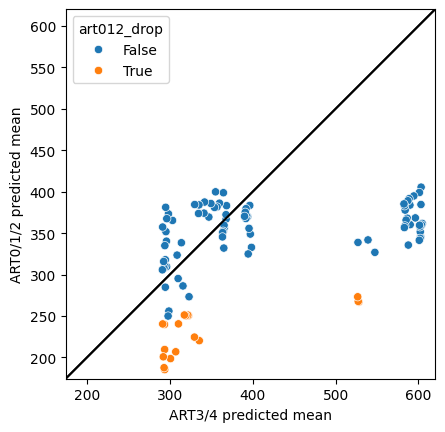

In [37]:
fig, ax = plt.subplots()
sns.scatterplot(data = filtered_recs, x = 'pp_mean', y = 'art012_pp_mean', hue = 'art012_drop', ax = ax)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.axline((300,300), slope=1, color='black')
ax.set_xlabel('ART3/4 predicted mean')
ax.set_ylabel('ART0/1/2 predicted mean')

In [38]:
filtered_recs = filtered_recs.loc[~filtered_recs['art012_drop'],:]

### Get final recs from filtered rec list
Get the top N recs from the filtered set

In [39]:
filtered_recs

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name,art012_pp_mean,art012_pp_std,art012_drop
64095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,604.560826,57.238152,4,0,False,1,PP_0368_PP_0751_PP_0812_PP_0815,361.709215,48.626924,False
66548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,603.759234,57.064168,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_1769,359.827872,49.725108,False
66446,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,603.182441,57.152095,4,0,False,1,PP_0368_PP_0812_PP_0813_PP_0815,405.488874,48.525895,False
177201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,603.005291,57.170639,4,0,False,1,PP_0751_PP_0812_PP_0813_PP_0815,384.549541,48.566169,False
66551,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,602.587095,57.229088,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_2136,345.689825,48.550383,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,294.022559,57.113132,2,0,False,1,PP_0751_PP_1506,310.688030,48.290622,False
410,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,292.943187,57.154995,2,0,False,1,PP_0751_PP_4120,307.777201,48.161062,False
822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,292.627372,57.126275,2,0,False,1,PP_1317_PP_4191,315.799209,48.241757,False
228,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,291.378587,57.061361,2,0,False,1,PP_0528_PP_0813,357.356237,48.481320,False


In [40]:
n_grna_dict = {
    2: 25,
    3: 30,
    4: 5
}
top_n_recs = []

for n_grna in n_grna_dict.keys():
    print(n_grna)
    top_n_recs.append(
        filtered_recs.loc[filtered_recs['number_of_grna'] == n_grna, :].sort_values('pp_mean', ascending = False).head(n_grna_dict[n_grna])
    )
filtered_recs = pd.concat(top_n_recs)
filtered_recs.head(5)

2
3
4


,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name,art012_pp_mean,art012_pp_std,art012_drop
632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,547.410360,57.153103,2,0,False,1,PP_0815_PP_2136,326.826503,48.389127,False
177,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,539.098996,57.250906,2,0,False,1,PP_0437_PP_0815,341.823580,48.385082,False
652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,527.021254,57.221514,2,0,False,1,PP_0815_PP_4191,338.823535,48.203893,False
114,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,323.234530,56.983768,2,0,False,1,PP_0368_PP_0437,273.309338,48.156685,False
387,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,315.899567,57.104941,2,0,False,1,PP_0751_PP_1317,286.338809,48.317514,False


In [41]:
filtered_recs = filtered_recs.drop(columns=['art012_pp_mean', 'art012_pp_std', 'art012_drop']).sort_values('pp_mean', ascending = False).reset_index(drop = True)

In [42]:
filtered_recs

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,604.560826,57.238152,4,0,False,1,PP_0368_PP_0751_PP_0812_PP_0815
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,603.759234,57.064168,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_1769
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,603.182441,57.152095,4,0,False,1,PP_0368_PP_0812_PP_0813_PP_0815
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,603.005291,57.170639,4,0,False,1,PP_0751_PP_0812_PP_0813_PP_0815
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,602.587095,57.229088,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_2136
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,602.154143,57.114361,3,0,False,1,PP_0751_PP_0812_PP_0815
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,596.214511,57.099916,3,0,False,1,PP_0812_PP_0814_PP_0815
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,594.351460,57.090725,3,0,False,1,PP_0812_PP_0815_PP_4189
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,589.999060,57.131200,3,0,False,1,PP_0368_PP_0751_PP_0815
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,589.688851,57.073625,3,0,False,1,PP_0751_PP_0813_PP_0815


### 2.3 Plot gRNA identities and distributions for each recommendation

Import trained ART model:

In [43]:
with open(art_path, 'rb') as art_file:
    art = cloudpickle.load(art_file)

Define function to plot distributions

In [44]:
def plot_draws(preds, feature_columns, prev_max = None, title_text = None, figsize = (6,6)):
    
    fig, ax = plt.subplots(figsize = figsize)
    draws = art.post_pred_draws(preds.loc[:,feature_columns], n_samples = 1000)[0]
    draws_df = pd.DataFrame(data = draws, columns = preds['line_name'])
    draws_df = pd.melt(draws_df, value_vars= preds['line_name'], value_name = 'titer', var_name = 'Line Name')

    pal = sns.cubehelix_palette(10, rot=-0.45, start=0.0, dark=0.3, light=0.7, reverse=True)
    sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)
    if prev_max is not None:
        ax.axvline(prev_max, color = 'k', linestyle = '--', linewidth = 0.5)
    if title_text is not None:
        ax.set_title(title_text)    
    return fig

Sampling: [y]
/tmp/ipykernel_486/271477315.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)
/tmp/ipykernel_486/271477315.py:9: UserWarning: 
The palette list has fewer values (10) than needed (59) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)
Sampling: [y]
/tmp/ipykernel_486/271477315.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)


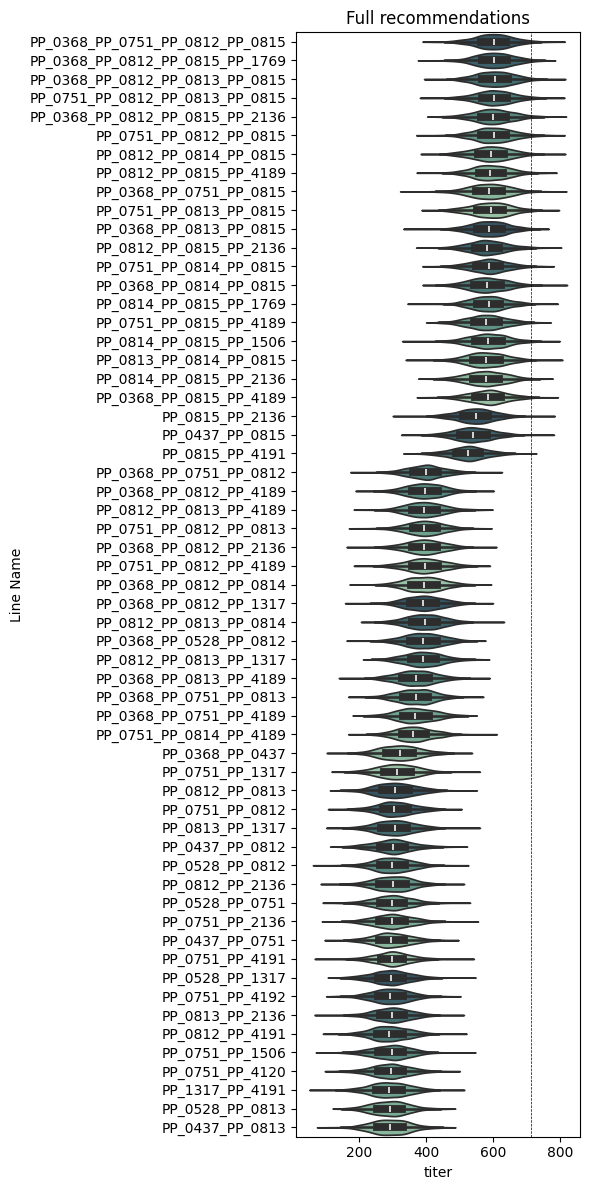

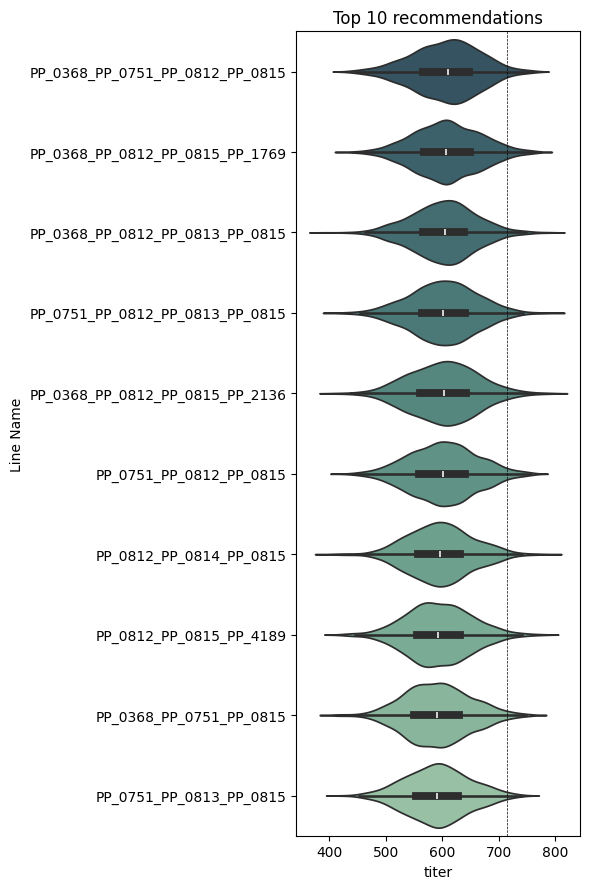

In [45]:
fig = plot_draws(filtered_recs,
                 feature_columns=pert_columns,
                 prev_max = data_df['isoprenol'].max(),
                 title_text = 'Full recommendations',
                 figsize = (6, 12))
fig.tight_layout()

fig.savefig(fig_loc + '/filtered_recs_draws_allrecs.png')

fig = plot_draws(filtered_recs.iloc[:10,:], 
                 feature_columns=pert_columns,
                 prev_max = data_df['isoprenol'].max(),
                 title_text = 'Top 10 recommendations',
                 figsize = (6, 9))
fig.tight_layout()

fig.savefig(fig_loc + '/filtered_recs_draws_top10recs.png')


In [46]:
grna_count = np.sum(filtered_recs.loc[:, pert_columns], axis = 0)
grna_count_df = pd.DataFrame(data = grna_count)
grna_count_df = grna_count_df.reset_index()
grna_count_df=grna_count_df.rename(columns={grna_count_df.columns.values[1]:'counts', 'index':'grna'})


Plot and format the counts datafame

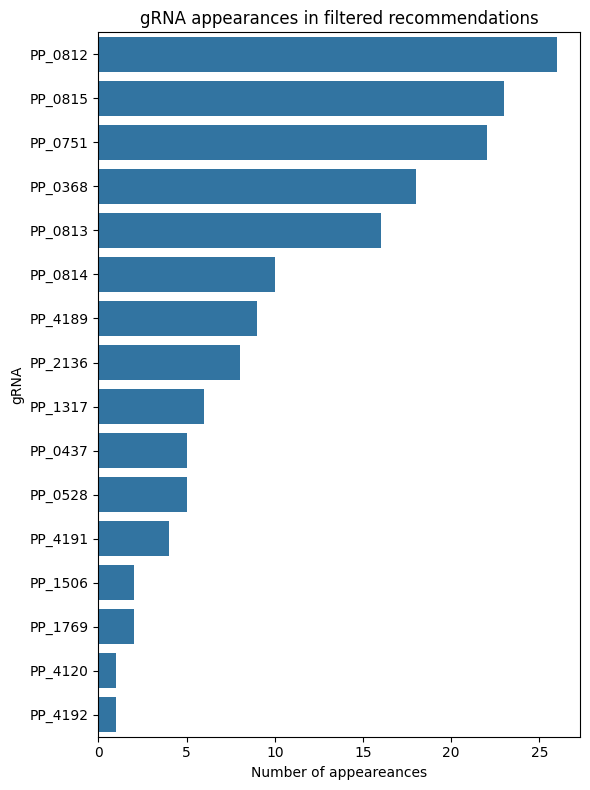

In [47]:
fig, ax = plt.subplots(figsize = (6,8))
sns.barplot(grna_count_df[grna_count_df['counts'] >0].sort_values(by = 'counts', ascending = False), x = 'counts', y = 'grna', ax = ax)
ax.set_title(f'gRNA appearances in filtered recommendations')
ax.set_xlabel('Number of appeareances')
ax.set_ylabel('gRNA')
fig.tight_layout()
fig.savefig(f'{fig_loc}gRNA_appearances_in_filtered_recs.png')

### 2.4 Save final recommendation as a dataframe

In [48]:
filtered_recs_export = filtered_recs.drop(columns=pert_columns)

In [49]:
filtered_recs

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,604.560826,57.238152,4,0,False,1,PP_0368_PP_0751_PP_0812_PP_0815
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,603.759234,57.064168,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_1769
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,603.182441,57.152095,4,0,False,1,PP_0368_PP_0812_PP_0813_PP_0815
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,603.005291,57.170639,4,0,False,1,PP_0751_PP_0812_PP_0813_PP_0815
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,602.587095,57.229088,4,0,False,1,PP_0368_PP_0812_PP_0815_PP_2136
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,602.154143,57.114361,3,0,False,1,PP_0751_PP_0812_PP_0815
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,596.214511,57.099916,3,0,False,1,PP_0812_PP_0814_PP_0815
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,594.351460,57.090725,3,0,False,1,PP_0812_PP_0815_PP_4189
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,589.999060,57.131200,3,0,False,1,PP_0368_PP_0751_PP_0815
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,589.688851,57.073625,3,0,False,1,PP_0751_PP_0813_PP_0815


In [50]:
filtered_recs_export
column_reorder = ['line_name', 'pp_mean', 'pp_std', 'number_of_grna', 'in_expt', 'to_rec']
filtered_recs_export = filtered_recs_export[column_reorder]
filtered_recs_export

,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
0,PP_0368_PP_0751_PP_0812_PP_0815,604.560826,57.238152,4,0,1
1,PP_0368_PP_0812_PP_0815_PP_1769,603.759234,57.064168,4,0,1
2,PP_0368_PP_0812_PP_0813_PP_0815,603.182441,57.152095,4,0,1
3,PP_0751_PP_0812_PP_0813_PP_0815,603.005291,57.170639,4,0,1
4,PP_0368_PP_0812_PP_0815_PP_2136,602.587095,57.229088,4,0,1
5,PP_0751_PP_0812_PP_0815,602.154143,57.114361,3,0,1
6,PP_0812_PP_0814_PP_0815,596.214511,57.099916,3,0,1
7,PP_0812_PP_0815_PP_4189,594.351460,57.090725,3,0,1
8,PP_0368_PP_0751_PP_0815,589.999060,57.131200,3,0,1
9,PP_0751_PP_0813_PP_0815,589.688851,57.073625,3,0,1


In [51]:
filtered_recs_export.to_csv(fig_loc + 'filtered_recs_for_dbtl5.csv')